# Gaussian Mixture Model using Expectation-maximization algorithm

In [1]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

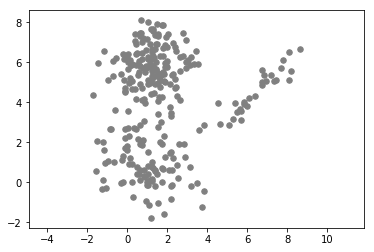

In [45]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

<b>E-Step</b>

In [46]:
from scipy.stats import multivariate_normal
def E_step(X, pi, mu, sigma):
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    ### YOUR CODE HERE
    x1 = multivariate_normal(mean = mu[0], cov = sigma[0])
    x2 = multivariate_normal(mean = mu[1], cov = sigma[1])
    x3 = multivariate_normal(mean = mu[2], cov = sigma[2])
    for i in range(N):
        Z = pi[0]*x1.pdf(X[i]) + pi[1]*x2.pdf(X[i]) + pi[2]*x3.pdf(X[i])
        gamma[i][0] = pi[0]*x1.pdf(X[i])/Z
        gamma[i][1] = pi[1]*x2.pdf(X[i])/Z
        gamma[i][2] = pi[2]*x3.pdf(X[i])/Z
    return gamma

In [47]:
gamma = E_step(X, pi0, mu0, sigma0)

Current answer for task Task 1 (E-step) is: 0.5337178741081263


<b>M-Step</b> 

In [159]:
def M_step(X, gamma):
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    mu = np.zeros((C, d))
    pi = np.zeros(C)
    sigma = np.zeros((C, d, d))
    for i in range(C):
        num = 0 
        denom = 0
        for j in range(N):
            num += gamma[j][i]*X[j]
            denom += gamma[j][i]
        mu[i] = num/denom

    for i in range(C):
        num = 0
        for j in range(N):
            num += gamma[j][i]*(np.outer((X[j]-mu[i]).T,(X[j]-mu[i])))
        sigma[i] = num/np.sum(gamma[:,i])
        
    for i in range(C):
        num = 0 
        for j in range(N):
            num += gamma[j][i]
        pi[i] = num/N
        
    return pi, mu, sigma

In [160]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)

Current answer for task Task 2 (M-step: mu) is: 2.899391882050383
Current answer for task Task 2 (M-step: sigma) is: 5.9771052168975265
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218776


### Loss function

In [162]:
import math
eps = np.finfo(float).eps
def compute_vlb(X, pi, mu, sigma, gamma):
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE+eps
    loss = 0
    for n in range(N):
        for c in range(C):
            loss += gamma[n][c]*np.log(pi[c]) + gamma[n][c]*multivariate_normal(mu[c],sigma[c]).logpdf(X[n]) - gamma[n][c]*np.log(gamma[n][c])
    return loss

In [163]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)

Current answer for task Task 3 (VLB) is: -1213.973464306019


### Bringing it all together

In [186]:
from sklearn.datasets import make_spd_matrix
from scipy import random, linalg
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            ### YOUR CODE HERE
            best_mu = mu0
            best_pi = pi0
            best_loss = -999999
            best_sigma = sigma0
            for i in range(max_iter):
                gamma = E_step(X, best_pi, best_mu, best_sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                if loss > best_loss:
                    best_loss = loss
                    best_mu = mu
                    best_pi = pi
                    best_sigma = sigma
            
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [187]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)

C:\Users\Rohit\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Current answer for task Task 4 (EM) is: -1213.973464306019


If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


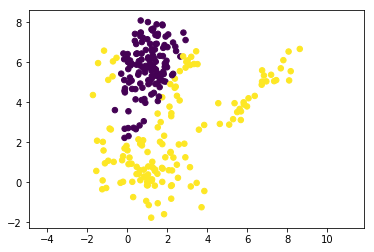

In [188]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()